In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Use inspector to determine column names and data types in tables
inspector = inspect(engine)

columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

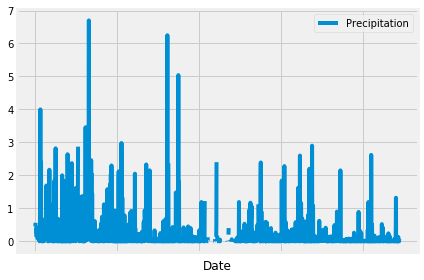

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

year_ago = dt.datetime.now() - dt.timedelta(365)
two_years_ago = year_ago - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date < year_ago)\
.filter(Measurement.date > two_years_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns=['Date','Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

df.iloc[::-1].plot()
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
print(f"The total number of stations in this data set is: {session.query(Station.station).count()}")

The total number of stations in this data set is: 9


In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()
                                                                                                        

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

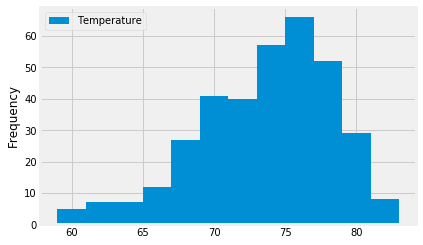

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get specific timeframe for query
year_ago = dt.datetime.now() - dt.timedelta(365)
two_years_ago = year_ago - dt.timedelta(365)

# Run query that returns both the station and the temperature observations, then filters based on the date range
# and on the station with highest number of observations
results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date < year_ago)\
.filter(Measurement.date > two_years_ago).filter(Measurement.station == 'USC00519281').all()

# Create a dataframe with the query
df = pd.DataFrame(results, columns=['Station','Temperature'])
df.set_index('Station', inplace=True)

# Plot as a histogram
df.plot.hist(bins=12)

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-18','2016-08-27'))

[(72.0, 78.3125, 84.0)]


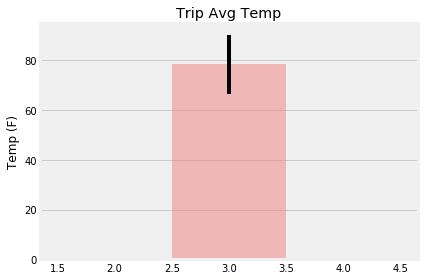

In [51]:
# Plot the results from your previous query as a bar chart. 

temp_obs = calc_temps('2016-08-18','2016-08-27')
temp = [x for x in temp_obs[0]]
x = [1.5,3,4.5]
width = [0,1,0]
x_label = "Average Temperature"
error = [0, temp[2] - temp[0], 0]

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
ax.bar(x, temp[1], yerr=error, align='center', color='lightcoral', width=width, alpha=0.5, ecolor='black')
ax.set_ylabel("Temp (F)")
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [63]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [64]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Use list comprehension to create a range of dates

base = dt.date(2016,8,27)
date_list = [base - dt.timedelta(days=x) for x in range(0, 10)]

# Stip off the year and save a list of %m-%d strings
month_day = [date_list[x].strftime("%m-%d") for x in range(0, 10)]

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in month_day:
    normals.append(daily_normals(date))
    print(daily_normals(date))


[(68.0, 76.28301886792453, 84.0)]
[(71.0, 76.56862745098039, 84.0)]
[(69.0, 76.96078431372548, 82.0)]
[(70.0, 75.96153846153847, 84.0)]
[(67.0, 76.6923076923077, 87.0)]
[(69.0, 76.47169811320755, 84.0)]
[(67.0, 76.4, 83.0)]
[(68.0, 76.45283018867924, 82.0)]
[(69.0, 75.94642857142857, 85.0)]
[(70.0, 76.92307692307692, 84.0)]


In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals)
normal_df.head()

,0
0,"(68.0, 76.28301886792453, 84.0)"
1,"(71.0, 76.56862745098039, 84.0)"
2,"(69.0, 76.96078431372548, 82.0)"
3,"(70.0, 75.96153846153847, 84.0)"
4,"(67.0, 76.6923076923077, 87.0)"


<IPython.core.display.Javascript object>


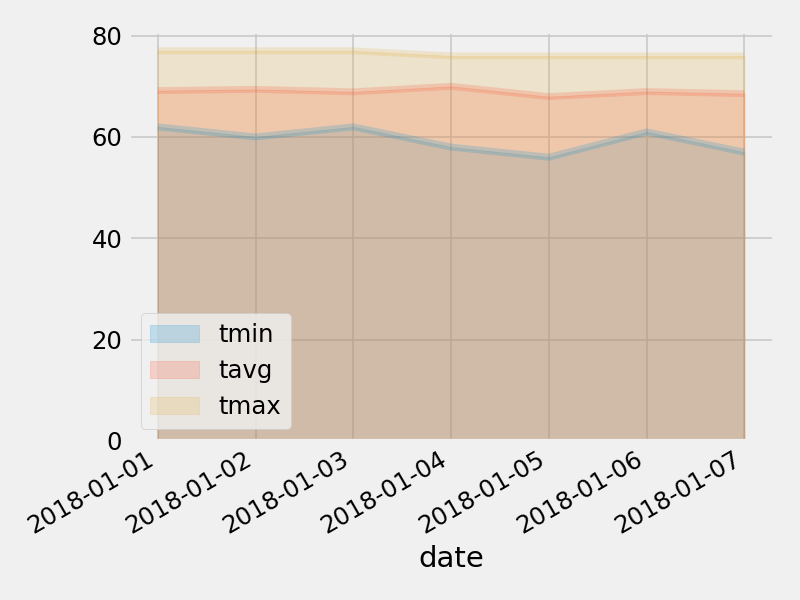

In [23]:
# Plot the daily normals as an area plot with `stacked=False`


In [15]:
request = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
        func.max(Measurement.tobs), Measurement.date).filter(Measurement.date >= '2014-05-15').all()

temp_dict = {}
temp_dict['min'] = request[0][0]
temp_dict['avg'] = request[0][1]
temp_dict['max'] = request[0][2]
real_date = request[0][3]

print(temp_dict)
print(real_date)

{'min': 56.0, 'avg': 74.24552133006831, 'max': 87.0}
2017-05-23
